# Actor-Critic

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Local packages
from src.systems.linear import StochasticDoubleIntegrator
from src.NeuralNetwork.ANN import NeuralNet
from src.RL.PolicyGradient.ActorCritic import *

The actor-critic is a method on the intersect between value-function and policy gradient methods.

### Vanilla gradient
We require some method of policy improvement. The more 'basic' method of policy improvement is the 'Vanilla' policy gradient. Here, the policy is improved following the gradient $\nabla_\theta J(\theta)$. As a result, the cost-to-go is optimized. As show earlier, the main challenge is to find this gradient. As seen in section REINFORCE, we have:

\begin{equation}
\nabla_\theta J(\theta) = \Big\langle \sum_{t=0}^H Q_{\pi_\theta} (s_t, u_t) \nabla_\theta \log \pi_\theta (u_t | s_t) \Big\rangle
\end{equation}

### Natural gradient
Natural gradient methods follow the path of steepest direction w.r.t. the Fisher Information (FI). That is:

\begin{equation}
\nabla_\theta J(\theta) = G^{-1} (\theta) \nabla J_\theta (\theta)
\end{equation}



In [9]:
class Critic:
    def __init__(self, network):
        self.network = network
        self.gamma = .9
    
    def TD_target(self, s1, reward):
        V1 = self.network.predict(s1)
        return reward + self.gamma * V1
    
    def get_value(self, state, learning=False):
        value = self.network.predict(state, learning=learning)
        return value

    def update(self, V0, s1, reward):
        target = self.TD_target(s1, reward)
        print(V0, target)
        self.network.update(V0, target)


class Actor:
    def __init__(self, key, dim):
        self.params = jrandom.normal(key, dim).T
    
    def get_control(self, state):
        return jnp.dot(self.params, state)

In [15]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

dim = (2, 1)
n_iter = 100

# initiate system
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

# initiate critic
architecture = (2, 1)
activation = ['linear']
NN = NeuralNet(key, architecture, activation)
critic = Critic(NN)

# initiate actor
actor = Actor(key, dim)

# saving
X = np.zeros((n_iter, dim[0]))
C = np.zeros(n_iter)
T = np.zeros(n_iter)

y0 = SDI.observe(key)

for i in range(n_iter):
    value = critic.get_value(y0, learning=True)
    u_star = actor.get_control(y0)
    state, cost, done = SDI.update(key, u_star, info=True)
    y1 = SDI.observe(subkey)
    print(value, y1, -cost[0])
    critic.update(value, y1, -cost[0])

    X[i] = state
    C[i] = cost
    #T[i] = TD

    # step
    key, subkey = jrandom.split(key)
    y0 = y1
    V0 = V1

-0.09900067 [ 2.         -0.12240885] -4.0049005
-0.09900067 -4.0156093


ValueError: axis 1 is out of bounds for array of dimension 0

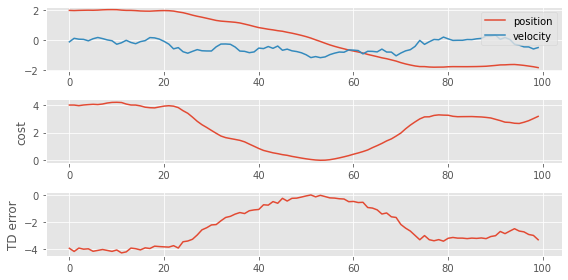

In [3]:
labels = {'y': [None, 'cost', 'TD error']}

fig, ax = plt.subplots(3, figsize=(8,4))
ax[0].plot(X[:, 0], label='position')
ax[0].plot(X[:, -1], label='velocity')
ax[0].legend()
ax[1].plot(C)
ax[2].plot(T)
for i in range(3):
    ax[i].set_ylabel(labels['y'][i])
plt.tight_layout()

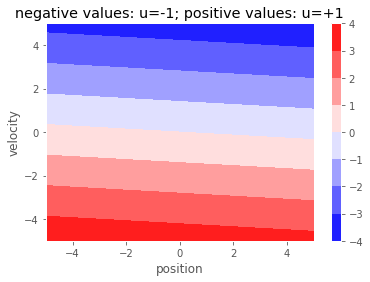

In [4]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
z = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        u_val = critic.get_value(jnp.array([xv[i,j], yv[i,j]]))
        z[i,j] = u_val

plt.contourf(xv, yv, z, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('negative values: u=-1; positive values: u=+1');

# TD Advantage Actor-Critic

In [19]:
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
from src.systems.linear import StochasticDoubleIntegrator
from src.NeuralNetwork.ANN import NeuralNet

import matplotlib.pyplot as plt

key = jrandom.PRNGKey(0)
n_obs = 2

# Initialize system
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

critic = NeuralNet(key, (n_obs, 1), ['linear'])
actor = NeuralNet(key, (n_obs, 1), ['linear'])


In [16]:

n_iter = 10
T = 10

gamma = .9

key, subkey = jrandom.split(key)

for i in range(n_iter):
    for ti in range(T):
        # observe state
        y0 = SDI.observe(key)

        # sample control
        mu = actor.predict(y0)
        sigma = .5
        u = mu + np.random.normal() * sigma

        # execute control & observe cost and new state
        state, cost = SDI.update(key, u)
        y1 = SDI.observe(subkey)

        # set TD target
        V1 = critic.predict(y1)
        target = -cost + gamma * V1

        # update critic by minimizing loss
        critic.train_step(y0, target)

        # update actor policy by minimizing loss
        
        # update state

## Continuous control

In [9]:

import numpy as np
import jax.numpy as jnp
import jax.random as jrandom
from src.systems.linear import StochasticDoubleIntegrator
from jax import value_and_grad

import matplotlib.pyplot as plt

key = jrandom.PRNGKey(0)
n_obs = 2

# initiate system
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

params = jrandom.normal(key, (n_obs, ))
eta = 1e-6

def loss(params, state, control, reward):
    mu = jnp.dot(params, state)
    sigma = .5

    pd_value = jnp.exp(-.5*((control - mu) / sigma)**2) / (sigma * jnp.sqrt(2*jnp.pi))

    log_prob = jnp.log(pd_value + 1e-5)

    loss = - reward * log_prob

    return loss

In [10]:
n_iter = 100

P = np.zeros((n_iter, n_obs))
G = np.zeros(n_iter)
D = np.zeros(n_iter)

for i in range(n_iter):
    y0 = SDI.observe(key)
    mu = jnp.dot(params, y0)
    sigma = .5
    u = float(mu + jrandom.normal(subkey, (1,))*sigma)
    state, cost = SDI.update(key, u, info=True)

    lvals, grads = value_and_grad(loss)(params, y0, u, -cost)
    
    params += eta*grads
    P[i] = params
    D[i] = np.arctan2(params[0], params[1])
    G[i] = np.arctan2(grads[0], grads[1])

    key, subkey = jrandom.split(key)

    if state[0] >= 5:
        SDI.reset(x0)



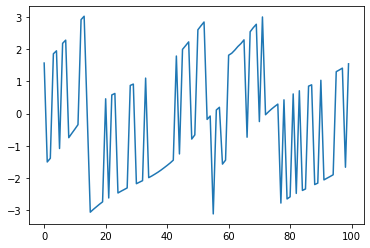

In [11]:
fig, ax = plt.subplots()
ax.plot(G)

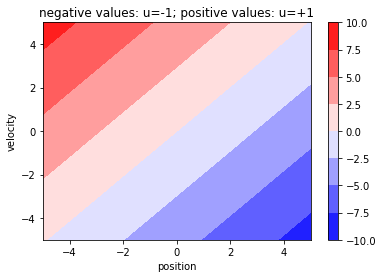

In [4]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
z = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        u_val = jnp.dot(params, jnp.array([xv[i,j], yv[i,j]]))
        z[i,j] = u_val

plt.contourf(xv, yv, z, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('negative values: u=-1; positive values: u=+1');